In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

C:\Users\Payanshi\Anaconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_train_valid_loader(data_dir,
                           batch_size,
                           random_seed,
                           augment=False,
                           valid_size=0.2,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True):
    """
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transforms
    valid_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])
    if augment:
        train_transform = transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize
        ])
    else:
        train_transform = transforms.Compose([
            transforms.ToTensor(),
            normalize
        ])

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=train_transform)

    valid_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=valid_transform)

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(train_dataset, 
                    batch_size=batch_size, sampler=train_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)

    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                    batch_size=batch_size, sampler=valid_sampler, 
                    num_workers=num_workers, pin_memory=pin_memory)


    # visualize some images
    if show_sample:
        sample_loader = torch.utils.data.DataLoader(train_dataset, 
                                                    batch_size=9, 
                                                    shuffle=shuffle, 
                                                    num_workers=num_workers,
                                                    pin_memory=pin_memory)
        data_iter = iter(sample_loader)
        images, labels = data_iter.next()
        X = images.numpy()
        plot_images(X, labels)

    return (train_loader, valid_loader)

In [3]:
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True):
    """
    Utility function for loading and returning a multi-process 
    test iterator over the MNIST dataset.
    If using CUDA, num_workers should be set to 1 and pin_memory to True.
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - shuffle: whether to shuffle the dataset after every epoch.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - data_loader: test set iterator.
    """
    normalize = transforms.Normalize((0.1307,), (0.3081,))  # MNIST

    # define transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])

    dataset = datasets.MNIST(root=data_dir, 
                               train=False, 
                               download=True,
                               transform=transform)

    data_loader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              shuffle=shuffle, 
                                              num_workers=num_workers,
                                              pin_memory=pin_memory)

    return data_loader

In [4]:
train_loader, valid_loader = get_train_valid_loader('../mnist_data',
                           batch_size = 16,
                           random_seed = 100,
                           augment=False,
                           valid_size=1/6,
                           shuffle=True,
                           show_sample=False,
                           num_workers=1,
                           pin_memory=True)

In [5]:
test_loader = get_test_loader('../mnist_data', 
                    batch_size=10,
                    shuffle=True,
                    num_workers=1,
                    pin_memory=True)

In [6]:
loaders = {'train': train_loader,
          'test': test_loader,
          'val': valid_loader} 

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        #
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
                                   nn.ReLU(),
                                   nn.MaxPool2d(kernel_size=2),
                                  )
        self.conv2 = nn.Sequential(nn.Conv2d(16, 32, 3, 1, 1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2),
                                  )
        self.conv3 = nn.Sequential(nn.Conv2d(32, 64, 3, 1, 1),
                                  nn.ReLU(),
                                  nn.MaxPool2d(kernel_size=2),
                                  )
        self.out = nn.Linear(64*3*3, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        x = torch.flatten(x, 1)
        x = self.out(x)
        
        return x

In [8]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=576, out_features=10, bias=True)
)


### Loss Function and Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr=0.0001)

In [10]:
num_epochs = 10 #5
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
    
    train_loss_list = []
    train_mean_loss_list = []
    train_acc_list = []
    train_correct = 0
    train_total = 0
    val_correct = 0
    val_total = 0
    val_acc_list = []
    
    for epoch in range(num_epochs):
        mean_loss = []
        for i, (images, labels) in enumerate(loaders['train']):
            
        
            outputs = cnn(images)              
            loss = criterion(outputs, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            train_acc =100.*train_correct/train_total
            
            if (i+1) % 1000 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Acc : {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), train_acc))
                
                pass
            mean_loss.append(loss.item())
        
        train_mean_loss_list.append(np.mean(mean_loss))
        train_loss_list.append(loss.item())
        train_acc_list.append(train_acc)
        
       
        # since we're not training, we don't need to calculate the gradients for our outputs
        with torch.no_grad():
            for data in loaders['val']: #valid_loader:
                images, labels = data
                # calculate outputs by running images through the network
                val_outputs = cnn(images)
                # the class with the highest energy is what we choose as prediction
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (val_predicted == labels).sum().item()
                val_acc =100.*val_correct/val_total
                
        val_acc_list.append(val_acc)
        
        pass
        
    
    
    pass
    return(train_loss_list, train_acc_list, val_acc_list, train_mean_loss_list)
    
train_loss_list, train_acc_list, val_acc_list, train_mean_loss_list = train(num_epochs, cnn, loaders)

Epoch [1/10], Step [1000/3125], Loss: 0.2246, Acc : 81.2562
Epoch [1/10], Step [2000/3125], Loss: 0.1195, Acc : 87.7562
Epoch [1/10], Step [3000/3125], Loss: 0.0368, Acc : 90.4146
Epoch [2/10], Step [1000/3125], Loss: 0.1074, Acc : 92.0818
Epoch [2/10], Step [2000/3125], Loss: 0.0719, Acc : 93.0195
Epoch [2/10], Step [3000/3125], Loss: 0.0509, Acc : 93.7133
Epoch [3/10], Step [1000/3125], Loss: 0.1264, Acc : 94.2974
Epoch [3/10], Step [2000/3125], Loss: 0.0058, Acc : 94.7348
Epoch [3/10], Step [3000/3125], Loss: 0.0665, Acc : 95.0682
Epoch [4/10], Step [1000/3125], Loss: 0.0075, Acc : 95.3988
Epoch [4/10], Step [2000/3125], Loss: 0.0073, Acc : 95.6330
Epoch [4/10], Step [3000/3125], Loss: 0.1275, Acc : 95.8434
Epoch [5/10], Step [1000/3125], Loss: 0.0715, Acc : 96.0648
Epoch [5/10], Step [2000/3125], Loss: 0.0289, Acc : 96.2345
Epoch [5/10], Step [3000/3125], Loss: 0.1548, Acc : 96.3786
Epoch [6/10], Step [1000/3125], Loss: 0.0079, Acc : 96.5244
Epoch [6/10], Step [2000/3125], Loss: 0.

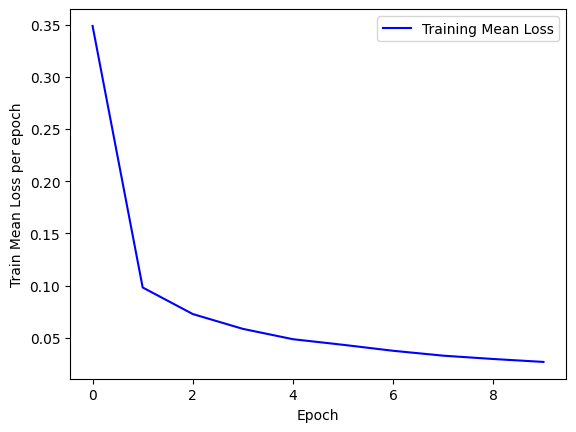

In [15]:
# Get training and test loss histories
df = pd.DataFrame(list(zip(train_loss_list, train_acc_list, val_acc_list,train_mean_loss_list )),columns =['Train_Loss', 'Train_Accuracy', 'Val_Accuracy', 'Train_Mean_Loss'])
training_mean_loss = df['Train_Mean_Loss']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_mean_loss, 'b')
plt.legend(['Training Mean Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Mean Loss per epoch')
plt.savefig("Training_Mean_Loss_Q7.png")
plt.show();

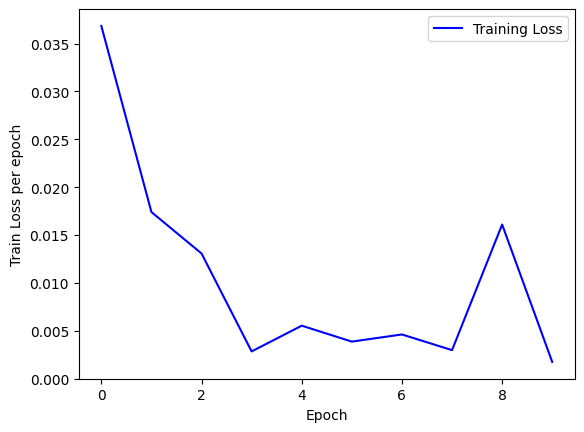

In [12]:
# Get training and test loss histories
df = pd.DataFrame(list(zip(train_loss_list, train_acc_list, val_acc_list )),columns =['Train_Loss', 'Train_Accuracy', 'Val_Accuracy'])
training_loss = df['Train_Loss']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_loss, 'b')
plt.legend(['Training Loss'])
plt.xlabel('Epoch')
plt.ylabel('Train Loss per epoch')
plt.savefig("Training_Loss_Q7.png")
plt.show();

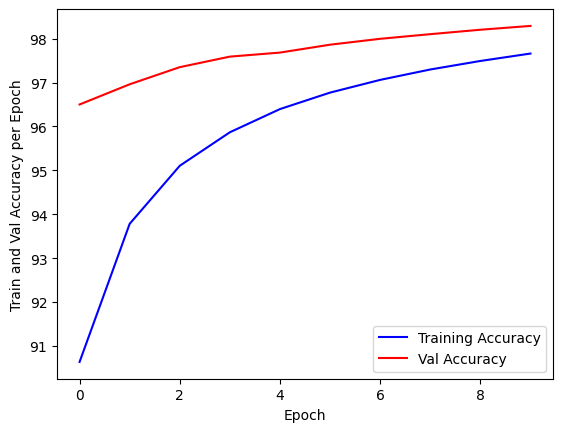

In [13]:
# Get training and test loss histories
# df = pd.DataFrame(list(zip(loss_list, acc_list)),columns =['Train_Accuracy', 'Val_Accuracy'])
training_acc = df['Train_Accuracy']
val_acc = df['Val_Accuracy']

# Create count of the number of epochs
epoch_count = num_epochs #(len(x_train)) #range(1, len(training_loss) + 1

# Visualize loss history
plt.plot(training_acc, 'b')
plt.plot(val_acc, 'r-')
plt.legend(['Training Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Train and Val Accuracy per Epoch')
plt.savefig("Accuracy_Q7.png")
plt.show();

In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = cnn(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %
